In [19]:
%matplotlib qt

# Energy calculator

Caculates the energy of a single Ho ion in the LiHoF<sub>4</sub> crystal.

In [2]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy import optimize
import math
import pandas as pd
import sys
import os

In [2]:
#constants
hbar=1
J=8
deg_J = 2 * J + 1
u_B=0.6717
g_L=5/4

In [3]:
# J matrices
jplus = hbar * np.diag(np.array( [ math.sqrt(J*(J+1) - m*(m+1)) for m in np.arange(-J,J) ] ), 1)
jminus = hbar * np.diag(np.array( [ math.sqrt(J*(J+1) - m*(m-1)) for m in np.arange(-J+1,J+1) ] ),-1)
jx = (jplus + jminus) * 0.5
jy = (jplus - jminus) * (-0.5j)
jz = hbar * np.diag(np.arange(-J,J+1))
I_J = np.diag(np.ones(int(round(deg_J))))


# crystal field equivalent operators
O02 = 3 * LA.matrix_power(jz,2) - J*(J+1)*I_J
O04 = 35 * LA.matrix_power(jz,4) - 30 * J * (J+1) * LA.matrix_power(jz,2) + 25*LA.matrix_power(jz,2) - 6 * J * (J+1) * I_J + 3 * J**2 * (J+1)**2 * I_J
O44C = 0.5 * (LA.matrix_power(jplus,4) + LA.matrix_power(jminus,4))
O06 = 231 * LA.matrix_power(jz,6) - 315*J*(J+1)*LA.matrix_power(jz,4) + 735*LA.matrix_power(jz,4) + 105 * J**2 * (J+1)**2 * LA.matrix_power(jz,2) - 525*J*(J+1)*LA.matrix_power(jz,2) + 294*LA.matrix_power(jz,2) - 5 * J**3 * (J+1)**3 * I_J + 40 * J**2 *(J+1)**2 * I_J - 60*J*(J+1)*I_J
O46C1 = 0.25 * (LA.matrix_power(jplus,4) + LA.matrix_power(jminus,4)) @ (11*LA.matrix_power(jz,2) - J*(J+1)*I_J - 38*I_J)
O46S1 = -0.25j * (LA.matrix_power(jplus,4) - LA.matrix_power(jminus,4)) @ (11 * LA.matrix_power(jz,2) - J*(J+1)*I_J - 38*I_J)
O46C = O46C1 + np.transpose(np.conj(O46C1))
O46S = O46S1 + np.transpose(np.conj(O46S1))


# crystal field parameters
B02 = -0.696
B04 = 4.06e-3
B06 =  4.64e-6
B44C = 0.0418
B46C = 8.12e-4
B46S = 1.137e-4


# crystal field Hamiltonian
H_cf = B02*O02 + B04*O04 + B06*O06 + B44C*O44C + B46C*O46C + B46S*O46S

In [17]:
# linear spacing for B:
Bx = np.linspace(-6,6,num=1601)
By = 0.0
Bz = 0.05

In [18]:
H = [H_cf - u_B*g_L*(bx*jx + By*jy + Bz*jz) for bx in Bx]    # zeeman term

In [19]:
res_up=[]
res_down=[]
moment=[]
for h in H:
    w,v = LA.eigh(h)
    res_up.append(w[0])
    res_down.append(w[1])
    moment.append(np.real(np.diagonal(np.conj(v.T)@jz@v)[0]))
res_up = np.array(res_up)
res_down = np.array(res_down)
moment = np.array(moment)

In [20]:
Bx[800]

0.0

In [23]:
moment[800]-moment[800+delta_bx_idx]

0.10245865802129295

5.409458273217776

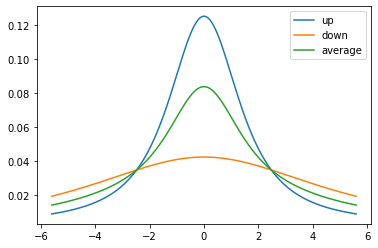

In [12]:
# plot energy decrease for a single ion when the transverse field is the average of a field in the 
# same direction of the external field and a field in the opposite direction. This is in comparison to no
# such fields - just the external field.
# This should provide a measure for the effectiveness of the ODD muchanism for any given external Bx.
delta_bx=0.4
delta_bx_idx = int(delta_bx/(Bx[1]-Bx[0]))
plt.plot(Bx[delta_bx_idx:-delta_bx_idx],(res_up - (np.roll(res_up,delta_bx_idx) + np.roll(res_up,-delta_bx_idx))*0.5)[delta_bx_idx:-delta_bx_idx],label='up')
plt.plot(Bx[delta_bx_idx:-delta_bx_idx],(res_down - (np.roll(res_down,delta_bx_idx) + np.roll(res_down,-delta_bx_idx))*0.5)[delta_bx_idx:-delta_bx_idx],label='down')
plt.plot(Bx[delta_bx_idx:-delta_bx_idx],(((res_up - (np.roll(res_up,delta_bx_idx) + np.roll(res_up,-delta_bx_idx))*0.5) + (res_down - (np.roll(res_down,delta_bx_idx) + np.roll(res_down,-delta_bx_idx))*0.5))*0.5)[delta_bx_idx:-delta_bx_idx],label='average')
plt.legend()

In [95]:
plt.plot(Bx,res_up)
plt.plot(Bx,res_down)

In [85]:
plt.close()

In [4]:
from scipy.optimize import curve_fit

In [55]:
def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

Gamma=2.234864537826931


C:\WPy64-3770\python-3.7.7.amd64\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


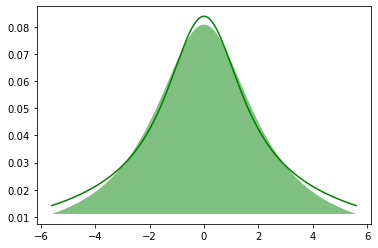

In [65]:
x_array=Bx[delta_bx_idx:-delta_bx_idx]
y_array=(((res_up - (np.roll(res_up,delta_bx_idx) + np.roll(res_up,-delta_bx_idx))*0.5) + (res_down - (np.roll(res_down,delta_bx_idx) + np.roll(res_down,-delta_bx_idx))*0.5))*0.5)[delta_bx_idx:-delta_bx_idx]
popt_lorentz, pcov_lorentz = curve_fit(lorentzian, x_array, y_array, p0=[0, 0.08, 3])
lorentz_peak = lorentzian(x_array, *popt_lorentz)
plt.plot(x_array,y_array,label='average',color="green")
plt.fill_between(x_array, lorentz_peak.min(), lorentz_peak, facecolor="green", alpha=0.5)
print('Gamma=' + str(popt_lorentz[2]))

In [52]:
def func1( x, b, gamma ):
    return b*x**gamma
def func2( x, b, gamma ):
    return x*gamma + b

gamma=[-4.2874254  -2.02729505]
gamma=[-1.97198478 -3.2589671 ]
0.014670306263724342
0.012072520941728726


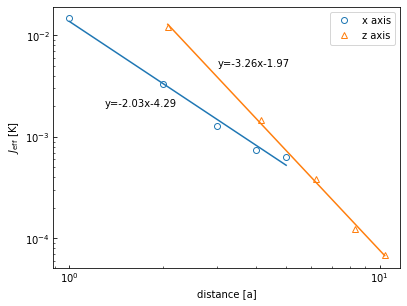

In [99]:
last_neighbor=5
fig, ax = plt.subplots(figsize=(6.22,4.8))
xdata_x=[1.0,2.0,3.0,4.0,5.0,6.0,7.0]
xdata_z=np.array([1.0,2.0,3.0,4.0,5.0,6.0,7.0])
xdata_z*=2.077294686
ydata_x_axis=0.25*np.array([0.05868122505489737, 0.013419913360849023, 0.005069568636827171, 0.0030055587412789464, 0.0025469184620305896, 0.0030055640963837504, 0.00506958260666579])
ydata_z_axis=0.25*np.array([0.048290083766914904, 0.005909063736908138, 0.001544987433589995, 4.984888946637511E-4, 2.733188448473811E-4, 4.984884290024638E-4, 0.0015449876664206386])
line_x=ax.plot(xdata_x[:last_neighbor],ydata_x_axis[:last_neighbor],label='x axis',marker='o',linestyle='',fillstyle='none')
line_z=ax.plot(xdata_z[:last_neighbor],ydata_z_axis[:last_neighbor],label='z axis',marker='^',linestyle='',fillstyle='none')
pz = curve_fit(func2, np.log(xdata_z[:last_neighbor]), np.log(ydata_z_axis[:last_neighbor]), p0=[1, 1])
px = curve_fit(func2, np.log(xdata_x[:last_neighbor]), np.log(ydata_x_axis[:last_neighbor]), p0=[1, 1])
# plt.plot(xdata, func1(xdata, *p[0]), label='x axis fit')
print('gamma='+str(px[0]))
print('gamma='+str(pz[0]))
ax.plot(xdata_x[:last_neighbor],func1(xdata_x[:last_neighbor], math.e**px[0][0], px[0][1]),linestyle='solid',color=line_x[0].get_color())
ax.plot(xdata_z[:last_neighbor],func1(xdata_z[:last_neighbor], math.e**pz[0][0], pz[0][1]),linestyle='solid',color=line_z[0].get_color())
ax.text(1.3,0.002,"y=%.2fx%.2f"%(px[0][1],px[0][0]))
ax.text(3,0.005,"y=%.2fx%.2f"%(pz[0][1],pz[0][0]))
ax.set_xlabel('distance [a]')
ax.set_ylabel('$J_{\mathrm{eff}}$ [K]')
# ax.set_xlim((.9,10.))
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(direction="in",which="both") 
ax.legend()
print(ydata_x_axis[0])
print(ydata_z_axis[0])
fig.savefig('./figures/effective_int.pdf')

In [52]:
fig.savefig('excess_AFM_energy.png')

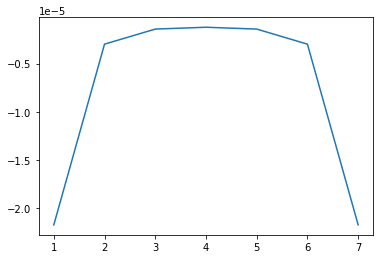

In [5]:
x=[1,2,3,4,5,6,7]
y=[-2.1721352823078632E-5, -2.9846560209989548E-6, -1.421663910150528E-6, -1.2315576896071434E-6, -1.420790795236826E-6, -2.9846560209989548E-6, -2.1721411030739546E-5]
plt.plot(x,y)